# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from statsmodels.formula.api import logit

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)


<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.



**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
# Know the number of rows in the dataset:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [4]:
# Number of unique users in the dataset using (nuinque):
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [5]:
# the probability of the users convereted 
converted_prop = (df['converted']).mean()
converted_prop

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [6]:
# the count of numbers that the treatment group doesn't match with the new page
not_match = df.query("group == 'treatment' and landing_page == 'old_page'").shape[0]
not_match

1965

**f.** Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**There isn't any null values in the dataset**

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
# filtering the dataset with the inaccurate rows that max up the treatment group with old page and the control group with new page
inaccurate_rows = df.query("group == 'treatment' & landing_page !=  'new_page' | group == 'control' & landing_page != 'old_page'")
inaccurate_rows.count() 

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [9]:
# adding a new dataframe 
df2 = df.drop(inaccurate_rows.index, axis = 0)

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
# using duplicated function to know the repeated user_id
user_repeated = df2[df2.duplicated(subset= 'user_id')]
user_repeated

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [13]:
# more info on the repeated rows
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(1899, inplace= True)

In [15]:
# Check again if the row with a duplicate user_id is deleted or not
df2[df2.duplicated(subset= 'user_id')]

,user_id,timestamp,group,landing_page,converted



**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [16]:

p_population = (df2['converted'] == 1).mean()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
converted_control = df2.query("group == 'control'").converted.mean()
converted_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
converted_treatment = df2.query("group == 'treatment'").converted.mean()
converted_treatment

0.11880806551510564

In [19]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = converted_control - converted_treatment
obs_diff

0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [20]:
# the probability of receiving the new page
(df['landing_page'] == 'new_page').mean()

0.5

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.


>- The conversion probability of the control group is .12 and the treatment group is .11 and the observed differece between them is **.001**
>- the probability that the individual received the new page is 50% same as the old page.

> **So I don't think there is sufficient evidence to say that the new treatment page leads to more conversions or not.**


<a id='ab_test'></a>
## Part II - A/B Test

>Since I've just calculated that the convereted probability of the control is slightly higher than the converted   probability of the treatment , So the null hypothesis will be that the old page is better than the new page untill I prove the opposite , so the alternative hypothesis will be that the new page is better than the old page with type | error rate of 5%.
>$$H_{0}:P_{old} \leq P_{new}$$
>$$H_{1}:P_{old} > P_{new}$$

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [21]:
# assuming that the new page equal to the converted under the null hypothesis the new page will be :
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [22]:
# assuming that the old page equal to the converted under the null hypothesis the old page will be :
p_old = p_new
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>


In [23]:
# number of the individuals in the treatment group
n_new = df2.query("group=='treatment'").user_id.nunique()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2.query("group=='control'").user_id.nunique()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 



In [25]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1-p_new) ,p_new])
new_page_converted.mean()

0.11916592113412704

**f. Simulate Sample for the `control` Group** <br>


In [26]:
# Simulate a Sample for the control Group
old_page_converted=np.random.choice([0,1], size=n_old, p=[(1-p_old), p_old])
old_page_converted.mean()

0.11921610198659086

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [27]:
converted_diff =new_page_converted.mean() - old_page_converted.mean()
converted_diff

-5.018085246381865e-05

**h. Sampling distribution** <br>


In [28]:
# Sampling distribution using numpy built-in fuctions:

p_diffss=[]

new_p_converted = np.random.binomial(n_new, p_new, 10000)/n_new

old_p_converted = np.random.binomial(n_old, p_old, 10000)/n_old

p_diffss = new_p_converted - old_p_converted 

In [29]:
# Calculating the confidence interval (95%):

lower_bound = np.percentile(p_diffss, 2.5)
upper_bound = np.percentile(p_diffss, 97.5)

print(lower_bound, upper_bound)

-0.002335591513696895 0.0023177195288087414


so here the difference between the old page and the new page with 95% confidence interval is between **-0.002 and 0.002**

### Plotting the sampling distribution for p.diffs with 95% confidence:

In [30]:
old_prob = df2.query("group=='control'")['converted'].mean()
new_prob=df2.query("group=='treatment'")['converted'].mean()
obs_diff=new_prob-old_prob
obs_diff

-0.0015782389853555567

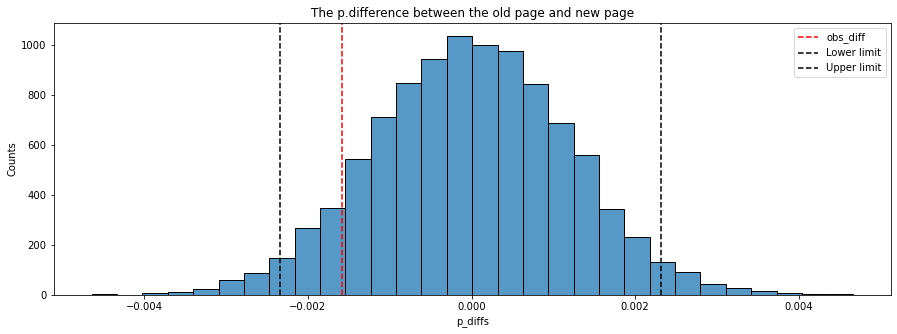

In [31]:
plt.figure(figsize=(15,5))

sns.histplot(p_diffss, bins= 30)
plt.axvline(obs_diff, label='obs_diff', c='r', ls='--')
plt.axvline(x=lower_bound, label='Lower limit', c='k', ls='--')
plt.axvline(x=upper_bound, label='Upper limit', c='k', ls='--')


plt.title('The p.difference between the old page and new page')
plt.xlabel('p_diffs')
plt.ylabel('Counts')

plt.legend();

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

### The sampling distribution of the difference under the null hypothesis:

In [32]:
# the null distribution 
null_distribution = np.random.normal(0, np.std(p_diffss), 10000) # Here are 10000 draws from the sampling distribution under the null

### Plotting the sampling distribution of the difference under the null hypothesis:

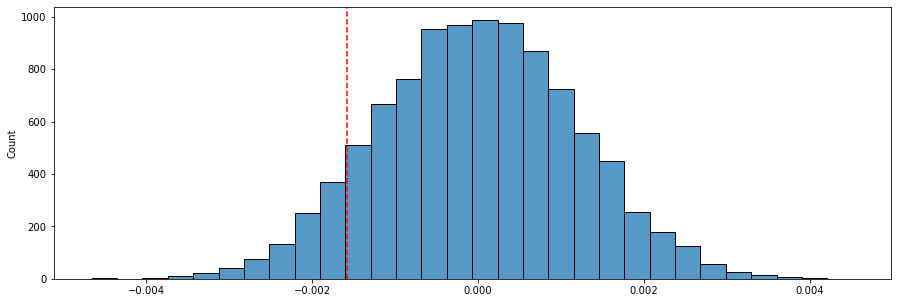

In [33]:
plt.figure(figsize=(15,5))
sns.histplot(x = null_distribution , bins=30)
plt.axvline(x= obs_diff, c='r', ls='--');

In [34]:
p_value = (null_distribution > obs_diff).mean()
p_value

0.9065

> The p value is .9 is greater than the alpha .05 so **I can't reject the null hypothesis**.

### using Z-testing for hypothesis testing 

In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("landing_page == 'old_page'")['converted'].sum()

# number of conversions with the new_page
convert_new = df2.query("landing_page == 'new_page'")['converted'].sum()

# number of individuals who were shown the old_page
n_old = df2.query("landing_page == 'old_page'")['user_id'].nunique()

# number of individuals who received new_page
n_new = df2.query("landing_page == 'new_page'")['user_id'].nunique()

print('The converted from old page is :', convert_old)
print('The converted from new page is :', convert_new)
print('The number of individuals who saw the old page :', n_old)
print('The number of individuals who saw the new page :', n_new)

The converted from old page is : 17489
The converted from new page is : 17264
The number of individuals who saw the old page : 145274
The number of individuals who saw the new page : 145310


In [36]:
# use sm.stats.proportions_ztest() to compute the test statistic and p-value.
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print("z_score = ",z_score)
print("p_value = ", p_value)

z_score =  -1.3109241984234394
p_value =  0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

- The z-score measures the number of standard errors.
- The findings from the traditional statistical methods agree with the findings before both have p value of = 0.9.


In [37]:
# making Contingency table to know the test of Independence:

Contingency_table = sm.stats.Table.from_data(df2[['landing_page', 'converted']])

In [38]:
# Testing for association:

result = Contingency_table.test_nominal_association()

In [39]:
# Getting results:

result.statistic, result.pvalue

(1.7185222540121794, 0.18988337448194548)

- I fail to reject the null hypothesis here who indicates that the two variables are independent. 
- the p value = 0.189 is greater than the alpha. 

<a id='regression'></a>
### Part III - A regression approach


**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression** : because the logistic regression model used to predict only two possible outcomes (conversion or no conversion).

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:


In [40]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [41]:
# Adding an intercept column :
df2['intercept'] = 1

# getting dummies :
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment'] # to make the treatment 1

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [42]:
log_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

result1 = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [43]:
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 09 Dec 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:01:00   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""


>- The null hypothesis here that there isn't a correlation between the ab_page and the conversion.
>- The null hypothesis here that there is a correlation between the two of them.

$$H_{0}:P_{new} - P_{old} = 0$$
$$H_{1}:P_{new} - P_{old} \neq 0$$


> It differs from part || because this is a two-sided t-test compared to a one-sided t-test in part II.

> The p value associated with ab_page is **0.190** which is higher than the alpha .05 . The p value here means that the probability of the correlation between x (ab_page) and y (converted) occurred by chance is 0.190 , SO there isn't a significant difference in conversion based on the page-type a customer receives. **I fail to reject the null**. 

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- Adding more features into the model may show us some patterns that is hidden. 
- The disadvantage: if these feautures don't relate to the data.

**g. Adding countries**<br> 


In [45]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [46]:
# Join with the df2 dataframe
df_joined = df2.merge(countries, on = 'user_id')
df_joined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [47]:
df_joined.groupby('country')['user_id'].nunique()

country
CA     14499
UK     72466
US    203619
Name: user_id, dtype: int64

To utilize two countries form the three, I will drop the least important (CA)

In [48]:
# Create the necessary dummy variables
df_joined[['CA','UK', 'US']] = pd.get_dummies(df_joined['country'])
df_joined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [49]:
# Initializing and fitting the model:
log_modell = sm.Logit(df_joined['converted'], df_joined[['intercept', 'UK','US']])

resultt = log_modell.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [50]:
# Getting the model summary:
resultt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 09 Dec 2021   Pseudo R-squ.:               1.521e-05
Time:                        21:01:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

> The p value for UK and US is greater than the alpha so again **I fail to reject the null**.

In [51]:
# delete the CA column form the dataset 
df_joined.drop('CA', inplace= True, axis=1)


In [52]:
df_joined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1


In [53]:
# adding two columns to see the interaction between page and country and if there is a significant effects on conversion
df_joined['UK_ab'] = df_joined['ab_page'] * df_joined['UK']
df_joined['US_ab'] = df_joined['ab_page'] * df_joined['US']
df_joined.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,UK,US,UK_ab,US_ab
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0,0


In [54]:
# Fit your model

log_model2 = sm.Logit(df_joined['converted'] , df_joined[['intercept', 'ab_page', 'UK','US', 'UK_ab', 'US_ab']])

results2 = log_model2.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [55]:
# summarize the results
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 09 Dec 2021   Pseudo R-squ.:               3.482e-05
Time:                        21:01:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab          0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab          0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

> The p value of UK_ab and US_ab is greater than the alpha .05 which means that **the interaction of country and ab_page have no significant effect on the conversion rate**.

> **I fail to reject the null**.

## Conclusions

> **I can't reject the null hypothesis** for many reasons:
>- The p value for the hypothesis testing is greater than the alpha, So the difference between the old page and the new page is not significant and occured by chance.
>- In the regression model also the p value is greater than the alpha and the interaction between the countries and the pages are meaningless or don't have effect on the conversion rate.

> It seems that the old page is pretty good and enough ,But I can't say If we should continue with the new page or cancel it
because The dataset don't have more features.

> **I suggest to run the experiment longer to make the decision of whether to implement the new page or not**.